# 📈 Quantitative Assessment: Does M&E Quality Affect Outcome Ratings?

This notebook addresses the following question from the assignment:

> Assume that your manager has asked you to further explore the relationship between M&E Quality and Outcome Ratings, with the goal of quantitatively assessing whether higher M&E quality is associated with better outcome ratings in this set of projects.

The approach follows **Raimondo (2016)** and consists of three classical econometric strategies:
1. OLS regression
2. Ordered Logit regression
3. Propensity Score Matching (PSM)

Then, we extend the analysis using modern machine learning and interpretable AI:
- Supervised learning to predict outcome ratings
- Feature importance to assess contribution of M&E variables
- Accumulated Local Effects (ALE) to explore marginal effects
- Incorporation of textual analysis (sentiment) from IEG full evaluation PDFs


## 1. Setup and Data Loading

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mord import LogisticAT
from PyALE import ale
import optuna
from sklearn.neighbors import NearestNeighbors
import requests
import pdfplumber  # pip install pdfplumber
from io import BytesIO
from tqdm import tqdm
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

sns.set(style="whitegrid", font_scale=1.1)

# determine working directories (notebook CWD)
script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
data_dir = parent_dir + '\\1_Data'

# Output directory:
output = os.path.join(os.path.dirname(cwd), '3_Outputs')
output = "C:\\Users\\wb592581\\Documents\\"

# Read data
excel_file = os.path.join(data_dir, 'IEG_ICRR_PPAR_Ratings_2025-03-12.xlsx')
df = pd.read_excel(excel_file)

################################
####### DATA PREPARATION #######
################################

# Filter relevant projects: Human Development (HD) between 2015 and 2025
df2 = df[
    (df['Approval FY'] >= 2015) &
    (df['Approval FY'] <= 2025) &
    (df['Practice Group'] == 'HD')
].copy()

# Drop identifier and text-heavy columns
columns_to_drop = [
    'Data Source', 'Project ID', 'Project Name', 'Evaluation Date',
    'Practice Group', 'TXT'
]
df2.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mappings for categorical-to-numeric transformations
me_mapping = {'Negligible': 1, 'Modest': 2, 'Substantial': 3, 'High': 4}

rating_mapping = {
    'Highly Unsatisfactory': 1, 'Unsatisfactory': 2, 'Moderately Unsatisfactory': 3,
    'Moderately Satisfactory': 4, 'Satisfactory': 5, 'Highly Satisfactory': 6
}

volume_mapping = {
    'Less than 10 million': 1,
    '>=10 million & <25 million': 2,
    '>=25 million & <50 million': 3,
    '>=50 million & <100 million': 4,
    '>=100 million': 5
}

################################
####### VARIABLE CREATION ######
################################

# Monitoring & Evaluation quality score
df2['ME_score'] = df2['IEG Monitoring and Evaluation Quality Ratings'].map(me_mapping)
df2.drop(columns=['IEG Monitoring and Evaluation Quality Ratings'], inplace=True, errors='ignore')

# Outcome score
df2['outcome_score'] = df2['IEG Outcome Ratings'].map(rating_mapping)
df2.drop(columns=['IEG Outcome Ratings'], inplace=True, errors='ignore')

# Covariates: quality and performance ratings
df2['Quality at Entry (1=bad–6=good)'] = df2['IEG Quality at Entry Ratings'].map(rating_mapping)
df2['Quality of Supervision (1=bad–6=good)'] = df2['IEG Quality of Supervision Ratings'].map(rating_mapping)
df2['Bank Performance (1=bad–6=good)'] = df2['IEG Bank Performance Ratings'].map(rating_mapping)
df2.drop(columns=[
    'IEG Quality at Entry Ratings',
    'IEG Quality of Supervision Ratings',
    'IEG Bank Performance Ratings'
], inplace=True, errors='ignore')

# Project volume
df2['Volume (1=low–5=high)'] = df2['Project Volume'].map(volume_mapping)
df2.drop(columns=['Project Volume'], inplace=True, errors='ignore')

# Project duration
df2['Duration'] = df2['Closing FY'] - df2['Approval FY']

# Convert categorical variables into dummy/indicator variables
def create_dummies(df, categorical_vars, drop_first=True):
    return pd.get_dummies(df, columns=categorical_vars, drop_first=drop_first)

categorical_vars = [
    'Evaluation Type', 'Global Practice', 'Region', 'Country',
    'Country Lending Group', 'Agreement Type', 'Lending Instrument'
]

df2 = create_dummies(df2, categorical_vars)

# Drop missings
df2 = df2.dropna(subset=['ME_score', 'Country FCS Status'])

# Data for sentiment analysis 
df_text = df2.copy()
df2.drop(columns=['PDF', 'Lesson'], inplace=True, errors='ignore')

country_fe      = [col for col in df2.columns if col.startswith('Country_')]
region_fe       = [col for col in df2.columns if col.startswith('Region_')]
global_prac_fe  = [col for col in df2.columns if col.startswith('Global Practice_')]

project_char = ['Approval FY', 'Closing FY', 'Duration', 'Volume (1=low–5=high)', 'Country FCS Status',
                'Quality at Entry (1=bad–6=good)', 'Quality of Supervision (1=bad–6=good)', 'Bank Performance (1=bad–6=good)']

## 2. OLS Model
We start with a simple linear regression (OLS) to assess the relationship between M&E quality and outcome scores.

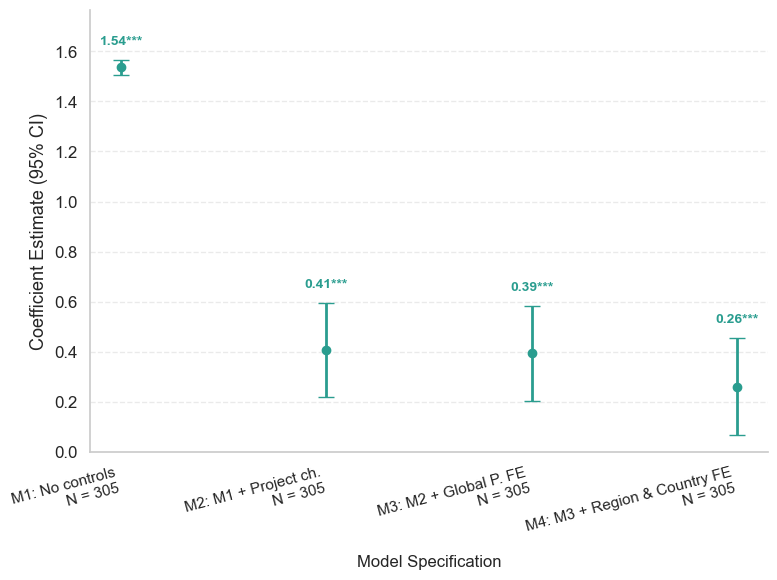

In [ ]:
# --------- STEP 1: Clean and transform booleans ----------
df2 = df2.copy()
bool_cols = df2.select_dtypes(include='bool').columns
df2[bool_cols] = df2[bool_cols].astype(int)

# --------- STEP 2: Define outcome ----------
y = df2['outcome_score'].astype(float)

# --------- STEP 3: Run models ----------
results, labels = [], []

# Model 1
X1 = df2[['ME_score']].copy()
model1 = sm.OLS(y, X1).fit()
results.append(model1)
labels.append("M1: No controls")

# Model 2
X2 = df2[['ME_score'] + project_char].copy()
model2 = sm.OLS(y, X2).fit()
results.append(model2)
labels.append("M2: M1 + Project ch.")

# Model 3
X3 = df2[['ME_score'] + project_char + global_prac_fe].copy()
model3 = sm.OLS(y, X3).fit()
results.append(model3)
labels.append("M3: M2 + Global P. FE")

# Model 4
X4 = df2[['ME_score'] + project_char + global_prac_fe + region_fe + country_fe].copy()
model4 = sm.OLS(y, X4).fit()
results.append(model4)
labels.append("M4: M3 + Region & Country FE")

# --------- STEP 4: Extract coefficients + N ----------
coef_data = []
for i, model in enumerate(results):
    coef = model.params['ME_score']
    ci_low, ci_up = model.conf_int().loc['ME_score']
    pval = model.pvalues['ME_score']
    n_obs = int(model.nobs)
    # Significance stars
    if pval < 0.01:
        stars = '***'
    elif pval < 0.05:
        stars = '**'
    elif pval < 0.1:
        stars = '*'
    else:
        stars = ''
    coef_data.append({
        'Label': labels[i],
        'Coef': coef,
        'CI_lower': ci_low,
        'CI_upper': ci_up,
        'P_value': pval,
        'N': n_obs,
        'Stars': stars
    })

coef_df = pd.DataFrame(coef_data)

# --------- STEP 5: Plot ----------
fig, ax = plt.subplots(figsize=(8, 6))
color = "#2a9d8f"

# Plot with error bars
ax.errorbar(
    x=range(len(coef_df)),
    y=coef_df['Coef'],
    yerr=[coef_df['Coef'] - coef_df['CI_lower'], coef_df['CI_upper'] - coef_df['Coef']],
    fmt='o',
    capsize=6,
    linewidth=2,
    color=color
)

# Add coefficient value above CI
for i, row in coef_df.iterrows():
    y_pos = row['CI_upper'] + 0.05  # Slightly above upper bound of CI
    ax.text(i, y_pos, f"{row['Coef']:.2f}{row['Stars']}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=color)

# Add N below x-axis labels
xtick_labels = [f"{row['Label']}\nN = {row['N']}" for _, row in coef_df.iterrows()]
ax.set_xticks(range(len(coef_df)))
ax.set_xticklabels(xtick_labels, rotation=15, ha='right', fontsize=11)

# Axis labels and title
ax.set_ylabel("Coefficient Estimate (95% CI)", fontsize=13)
ax.set_title("", fontsize=15, weight='bold')
ax.set_xlabel("Model Specification", fontsize=12)
ax.set_ylim(0, coef_df['CI_upper'].max() + 0.2)

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.grid(False, axis='x')

plt.tight_layout()
plt.savefig(output + "est_mco.png", dpi=300) 
plt.show()

## 3. Ordered Logit Model
We now fit an ordered logit model to account for the ordinal nature of the outcome ratings.

c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


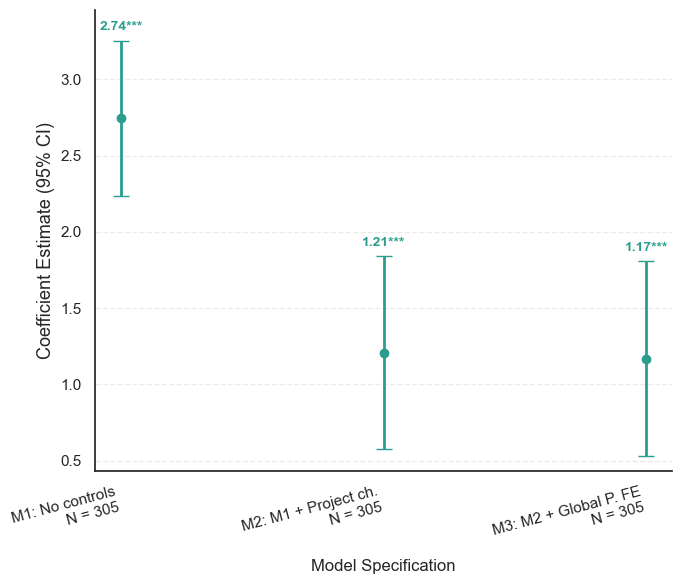

In [ ]:
# --------- STEP 1: Clean and transform booleans ----------
df2 = df2.copy()
bool_cols = df2.select_dtypes(include='bool').columns
df2[bool_cols] = df2[bool_cols].astype(int)

# --------- STEP 2: Ensure outcome is ordinal categorical ----------
y_ord = df2['outcome_score'].astype(int)

# --------- STEP 3: Define function to run Ordered Logit ----------
def run_ordered_logit(y, X):
    model = OrderedModel(y, X, distr='logit')
    result = model.fit(method='bfgs', disp=False)
    return result

# --------- STEP 4: Run models ----------
results, labels = [], []

X1 = df2[['ME_score']].copy()
res1 = run_ordered_logit(y_ord, X1)
results.append(res1)
labels.append("M1: No controls")

X2 = df2[['ME_score'] + project_char].copy()
res2 = run_ordered_logit(y_ord, X2)
results.append(res2)
labels.append("M2: M1 + Project ch.")

X3 = df2[['ME_score'] + project_char + global_prac_fe].copy()
res3 = run_ordered_logit(y_ord, X3)
results.append(res3)
labels.append("M3: M2 + Global P. FE")

# --------- STEP 5: Extract results ----------
coef_data = []
for i, model in enumerate(results):
    coef = model.params['ME_score']
    ci_low, ci_up = model.conf_int().loc['ME_score']
    pval = model.pvalues['ME_score']
    n_obs = int(model.model.nobs)
    
    # Significance stars
    if pval < 0.01:
        stars = '***'
    elif pval < 0.05:
        stars = '**'
    elif pval < 0.1:
        stars = '*'
    else:
        stars = ''
    
    coef_data.append({
        'Label': labels[i],
        'Coef': coef,
        'CI_lower': ci_low,
        'CI_upper': ci_up,
        'P_value': pval,
        'Stars': stars,
        'N': n_obs
    })

coef_df = pd.DataFrame(coef_data)

# --------- STEP 6: PLOT ----------
sns.set(style="white")
fig, ax = plt.subplots(figsize=(7, 6))
color = "#2a9d8f"

# Plot error bars
ax.errorbar(
    x=range(len(coef_df)),
    y=coef_df['Coef'],
    yerr=[coef_df['Coef'] - coef_df['CI_lower'], coef_df['CI_upper'] - coef_df['Coef']],
    fmt='o',
    capsize=6,
    linewidth=2,
    color=color
)

# Add coefficient values above CI
for i, row in coef_df.iterrows():
    y_pos = row['CI_upper'] + 0.05
    ax.text(i, y_pos, f"{row['Coef']:.2f}{row['Stars']}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=color)

# X-axis: model label + N
xtick_labels = [f"{row['Label']}\nN = {row['N']}" for _, row in coef_df.iterrows()]
ax.set_xticks(range(len(coef_df)))
ax.set_xticklabels(xtick_labels, rotation=15, ha='right', fontsize=11)

# Axis and title
ax.set_ylabel("Coefficient Estimate (95% CI)", fontsize=13)
ax.set_xlabel("Model Specification", fontsize=12)
ax.set_title("", fontsize=15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylim(min(coef_df['CI_lower']) - 0.1, max(coef_df['CI_upper']) + 0.2)

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig(output + "est_logit.png", dpi=300) 
plt.show()

## 4. Propensity Score Matching (PSM)
We estimate the average treatment effect of having high M&E quality (binary treatment) on outcome ratings using matching techniques.

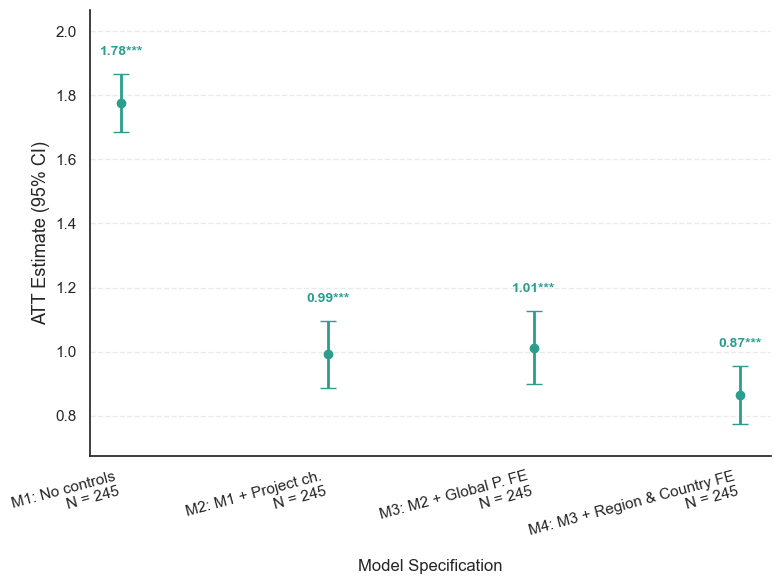

In [ ]:
# --------- STEP 1: Clean booleans ----------
df3 = df2.copy()
bool_cols = df3.select_dtypes(include='bool').columns
df3[bool_cols] = df3[bool_cols].astype(int)

# --------- STEP 2: Define variables ----------
y = df3['outcome_score'].astype(float)
df3['ME_high'] = (df3['ME_score'] >= 3).astype(int)
df3.drop(['ME_score'], inplace=True, errors='ignore')

treatment = 'ME_high'

# Define control sets
models = [
    [],  # Model 1: No controls
    project_char,  # Model 2
    project_char + global_prac_fe,  # Model 3
    project_char + global_prac_fe + region_fe + country_fe  # Model 4
]
labels = [
    "M1: No controls",
    "M2: M1 + Project ch.",
    "M3: M2 + Global P. FE",
    "M4: M3 + Region & Country FE"
]

# --------- STEP 3: Function to estimate ATT with CI ----------
def estimate_att_with_ci(df, treat_col, outcome_col, covariates):
    df = df.copy()
    X = df[covariates]
    T = df[treat_col]
    Y = df[outcome_col]

    # Estimate propensity scores
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X, T)
    df['pscore'] = model.predict_proba(X)[:, 1]

    # Split treated and control
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]

    # Nearest neighbor matching
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[['pscore']])
    distances, indices = nn.kneighbors(treated[['pscore']])
    matched_control_outcomes = control.iloc[indices.flatten()][outcome_col].values

    # ATT and CI
    diffs = treated[outcome_col].values - matched_control_outcomes
    att = np.mean(diffs)
    se = np.std(diffs, ddof=1) / np.sqrt(len(diffs))
    ci_low = att - 1.96 * se
    ci_high = att + 1.96 * se

    # Simple significance
    pval = 2 * (1 - abs((att / se))) if se != 0 else 1

    return att, ci_low, ci_high, pval, len(treated)

# --------- STEP 4: Run models ----------
att_data = []
for i, covars in enumerate(models):
    covars_to_use = covars if covars else ['ME_score']
    att, ci_low, ci_high, pval, n_obs = estimate_att_with_ci(df3, treatment, 'outcome_score', covars_to_use)

    if pval < 0.01:
        stars = '***'
    elif pval < 0.05:
        stars = '**'
    elif pval < 0.1:
        stars = '*'
    else:
        stars = ''

    att_data.append({
        'Label': labels[i],
        'ATT': att,
        'CI_lower': ci_low,
        'CI_upper': ci_high,
        'Stars': stars,
        'N': n_obs
    })

att_df = pd.DataFrame(att_data)

# --------- STEP 5: Plot ----------
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8, 6))
color = "#2a9d8f"

# Error bars
ax.errorbar(
    x=range(len(att_df)),
    y=att_df['ATT'],
    yerr=[att_df['ATT'] - att_df['CI_lower'], att_df['CI_upper'] - att_df['ATT']],
    fmt='o',
    capsize=6,
    linewidth=2,
    color=color
)

# Annotate ATT values with stars above CI
for i, row in att_df.iterrows():
    y_pos = row['CI_upper'] + 0.05
    ax.text(i, y_pos, f"{row['ATT']:.2f}{row['Stars']}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=color)

# X-axis with sample sizes
xtick_labels = [f"{row['Label']}\nN = {row['N']}" for _, row in att_df.iterrows()]
ax.set_xticks(range(len(att_df)))
ax.set_xticklabels(xtick_labels, rotation=15, ha='right', fontsize=11)

# Axes and titles
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel("ATT Estimate (95% CI)", fontsize=13)
ax.set_xlabel("Model Specification", fontsize=12)
ax.set_title("", fontsize=15, weight='bold')
ax.set_ylim(min(att_df['CI_lower']) - 0.1, max(att_df['CI_upper']) + 0.2)

# Aesthetic polish
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# Remove bold from axes
ax.tick_params(axis='both', which='major', labelsize=11)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('normal')

plt.tight_layout()
plt.savefig(output + "est_psm.png", dpi=300) 
plt.show()

## 5. Machine Learning Models
Now we use ML models (Random Forest, LightGBM) to predict outcome scores based on project characteristics and M&E ratings.

In [31]:
# --------- 1. Prepare data ----------
y = df2['outcome_score']
X = df2.drop(columns=['outcome_score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

original_columns = X_train.columns

def clean_column_names(df):
    df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    return df

X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

cleaned_columns = [re.sub(r'[^\w]', '_', col) for col in original_columns]
col_name_map = dict(zip(cleaned_columns, original_columns))

# --------- 2. Objective function for Optuna ----------
N_TRIALS = 40

def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['random_forest', 'lgbm', 'ordinal_logistic'])

    if model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'random_state': 42
        }
        model = RandomForestRegressor(**params)

    elif model_type == 'lgbm':
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'random_state': 42
        }
        model = LGBMRegressor(**params)

    else:  # ordinal_logistic
        alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )

    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_train, y_train, cv=3)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    return rmse

# --------- 3. Run Optuna ----------
study = optuna.create_study(direction='minimize')  # We want to minimize RMSE
study.optimize(objective, n_trials=N_TRIALS)

best_params = study.best_params
print("Best model type and parameters:", best_params)

[I 2025-06-23 00:49:49,811] A new study created in memory with name: no-name-a525e8c7-1a69-453e-aaae-288ff5796ee4
[I 2025-06-23 00:49:50,170] Trial 0 finished with value: 0.6069769786668839 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.01972451359120081}. Best is trial 0 with value: 0.6069769786668839.
[I 2025-06-23 00:49:51,263] Trial 1 finished with value: 0.5467836835342105 and parameters: {'model_type': 'random_forest', 'n_estimators': 288, 'max_depth': 9}. Best is trial 1 with value: 0.5467836835342105.
[I 2025-06-23 00:49:51,813] Trial 2 finished with value: 0.6764782640784645 and parameters: {'model_type': 'lgbm', 'num_leaves': 55, 'learning_rate': 0.017531123349237326, 'n_estimators': 103}. Best is trial 1 with value: 0.5467836835342105.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-23 00:49:52,830] Trial 3 finished with value: 0.5414314383403288 and parameters: {'model_type': 'random_forest', 'n_estimators': 249, 'max_depth': 20}. Best is trial 3 with value: 0.5414314383403288.
[I 2025-06-23 00:49:53,649] Trial 4 finished with value: 0.5404212526625269 and parameters: {'model_type': 'random_forest', 'n_estimators': 204, 'max_depth': 14}. Best is trial 4 with value: 0.5404212526625269.
[I 2025-06-23 00:49:54,793] Trial 5 finished with value: 0.6105792475542055 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.00012862349516682352}. Best is trial 4 with value: 0.5404212526625269.
[I 2025-06-23 00:49:56,353] Trial 6 finished with value: 0.6049028326758548 and parameters: {'model_type': 'random_forest', 'n_estimators': 227, 'max_depth': 3}. Best is trial 4 with value: 0.5404212526625269.
[I 2025-06-23 00:49:58,761] Trial 7 finished with value: 0.6105792475542055 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.00075470582148317}. B

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-23 00:50:01,105] Trial 10 finished with value: 0.5706756120933636 and parameters: {'model_type': 'lgbm', 'num_leaves': 97, 'learning_rate': 0.29329951691800155, 'n_estimators': 155}. Best is trial 4 with value: 0.5404212526625269.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-23 00:50:04,096] Trial 11 finished with value: 0.5415874976283616 and parameters: {'model_type': 'random_forest', 'n_estimators': 229, 'max_depth': 20}. Best is trial 4 with value: 0.5404212526625269.
[I 2025-06-23 00:50:08,450] Trial 12 finished with value: 0.5418809638466981 and parameters: {'model_type': 'random_forest', 'n_estimators': 271, 'max_depth': 20}. Best is trial 4 with value: 0.5404212526625269.
[I 2025-06-23 00:50:13,636] Trial 13 finished with value: 0.5414915854532367 and parameters: {'model_type': 'random_forest', 'n_estimators': 182, 'max_depth': 14}. Best is trial 4 with value: 0.5404212526625269.
[I 2025-06-23 00:50:19,617] Trial 14 finished with value: 0.5421066962344804 and parameters: {'model_type': 'random_forest', 'n_estimators': 238, 'max_depth': 13}. Best is trial 4 with value: 0.5404212526625269.
[I 2025-06-23 00:50:24,850] Trial 15 finished with value: 0.5417821310144094 and parameters: {'model_type': 'random_forest', 'n_estimators': 186, 'max_d

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-23 00:50:32,873] Trial 17 finished with value: 0.5788168728386348 and parameters: {'model_type': 'lgbm', 'num_leaves': 23, 'learning_rate': 0.15463145276838752, 'n_estimators': 145}. Best is trial 4 with value: 0.5404212526625269.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-23 00:50:38,418] Trial 18 finished with value: 0.5402436512711389 and parameters: {'model_type': 'random_forest', 'n_estimators': 208, 'max_depth': 17}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:50:43,006] Trial 19 finished with value: 0.540363554887416 and parameters: {'model_type': 'random_forest', 'n_estimators': 202, 'max_depth': 16}. Best is trial 18 with value: 0.5402436512711389.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-06-23 00:50:44,013] Trial 20 finished with value: 0.5742314990031355 and parameters: {'model_type': 'lgbm', 'num_leaves': 99, 'learning_rate': 0.27678383755704683, 'n_estimators': 205}. Best is trial 18 with value: 0.5402436512711389.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 20
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-23 00:50:49,970] Trial 21 finished with value: 0.5408520651780928 and parameters: {'model_type': 'random_forest', 'n_estimators': 207, 'max_depth': 16}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:50:53,933] Trial 22 finished with value: 0.5413597979336644 and parameters: {'model_type': 'random_forest', 'n_estimators': 165, 'max_depth': 16}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:50:58,272] Trial 23 finished with value: 0.5428321568552499 and parameters: {'model_type': 'random_forest', 'n_estimators': 213, 'max_depth': 11}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:51:01,269] Trial 24 finished with value: 0.5412676962369499 and parameters: {'model_type': 'random_forest', 'n_estimators': 184, 'max_depth': 17}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:51:03,148] Trial 25 finished with value: 0.5418478211425329 and parameters: {'model_type': 'random_forest', 'n_estimators': 130, 'm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-23 00:51:08,303] Trial 28 finished with value: 0.6358522208298014 and parameters: {'model_type': 'lgbm', 'num_leaves': 28, 'learning_rate': 0.027923612698196543, 'n_estimators': 171}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:51:10,619] Trial 29 finished with value: 0.5407233285432821 and parameters: {'model_type': 'random_forest', 'n_estimators': 199, 'max_depth': 15}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:51:10,958] Trial 30 finished with value: 0.6033532031234261 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 4.442399690404697}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:51:13,658] Trial 31 finished with value: 0.5407233285432821 and parameters: {'model_type': 'random_forest', 'n_estimators': 199, 'max_depth': 15}. Best is trial 18 with value: 0.5402436512711389.
[I 2025-06-23 00:51:15,943] Trial 32 finished with value: 0.5407801034313539 and parameters: {'model_type': 'random_forest',

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-23 00:51:26,845] Trial 38 finished with value: 0.5998595463229556 and parameters: {'model_type': 'lgbm', 'num_leaves': 69, 'learning_rate': 0.16037646299659492, 'n_estimators': 125}. Best is trial 36 with value: 0.5394776078377527.
[I 2025-06-23 00:51:28,248] Trial 39 finished with value: 0.5411113751649798 and parameters: {'model_type': 'random_forest', 'n_estimators': 102, 'max_depth': 19}. Best is trial 36 with value: 0.5394776078377527.


Best model type and parameters: {'model_type': 'random_forest', 'n_estimators': 170, 'max_depth': 19}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 21
[LightGBM] [Info] Start training from score 4.473684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

C:\Users\wb592581\AppData\Local\Temp\ipykernel_20920\4008972047.py:59: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=ax, palette=palette)


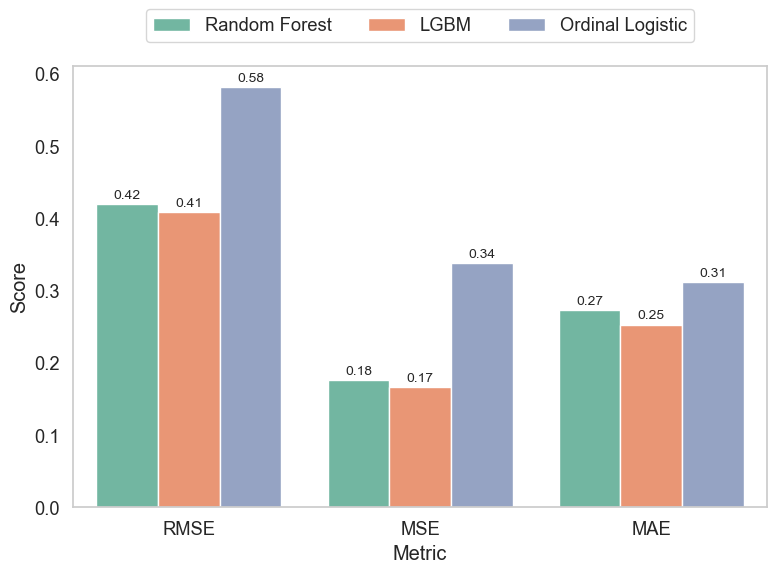

In [ ]:
results_train = []
results_test = []

for model_type in ['random_forest', 'lgbm', 'ordinal_logistic']:
    # Extract the best trial for the current model type
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    # For RMSE, select the trial with the lowest value
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instantiate model
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        label = 'Random Forest'
    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        label = 'LGBM'
    else:  # ordinal_logistic
        alpha = best_params['alpha']
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )
        label = 'Ordinal Logistic'

    # Train model
    model.fit(X_train, y_train)

    # TRAIN predictions
    y_train_pred = model.predict(X_train)
    results_train.append({
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred)
    })

    # TEST predictions
    y_test_pred = model.predict(X_test)
    results_test.append({
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred)
    })

# Reformat results
train_df = pd.DataFrame(results_train).melt(id_vars='Model', var_name='Metric', value_name='Score')
test_df = pd.DataFrame(results_test).melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
palette = sns.color_palette("Set2")
fig, ax = plt.subplots(figsize=(8, 6))

# TEST barplot
sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=ax, palette=palette)
ax.set_title("", fontsize=14)

# Add labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10, label_type='edge', padding=2)

# Final layout
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.grid(False, axis='y')

plt.tight_layout()
plt.savefig(output + "ml_metrics.png", dpi=300) 
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 21
[LightGBM] [Info] Start training from score 4.473684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

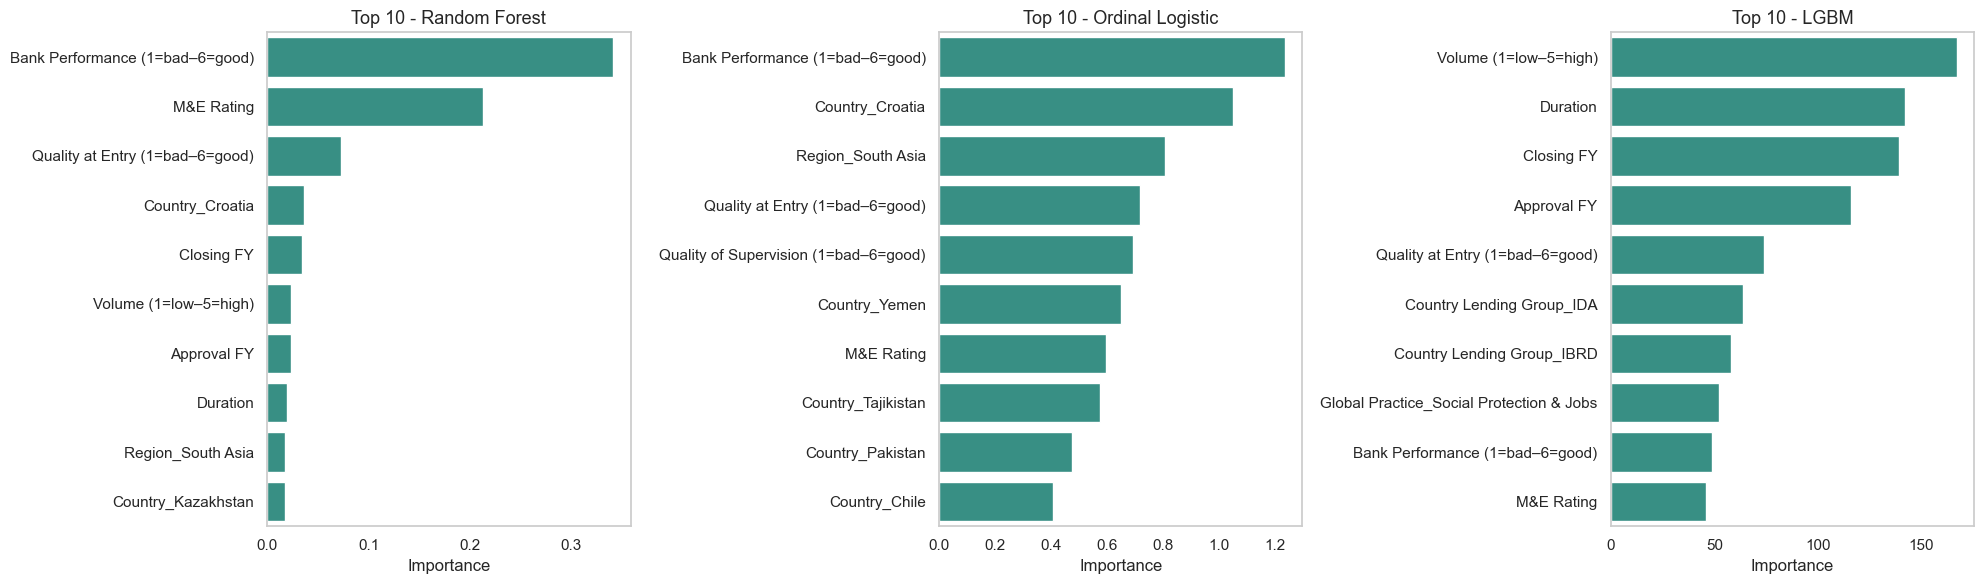

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.set(style="whitegrid")

for i, (model_type, label) in enumerate([
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]):
    # Find the best trial for this model
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)  # use min because we are minimizing RMSE
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instantiate and train the model
    if model_type == 'random_forest':
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    elif model_type == 'lgbm':
        from lightgbm import LGBMRegressor
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    else:  # ordinal_logistic
        from mord import LogisticAT
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import StandardScaler
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)
        # Extract coefficients from inner LogisticAT model
        coefs = model.named_steps['logisticat'].coef_
        importances = np.abs(coefs)

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(10)

    # Relabel "ME_score" to "M&E Rating"
    importance_df['feature'] = importance_df['feature'].map(lambda x: 'M&E Rating' if col_name_map[x] == 'ME_score' else col_name_map[x])

    # Plot
    sns.barplot(data=importance_df, x='importance', y='feature', ax=axs[i], color='#2a9d8f')
    axs[i].set_title(f"Top 10 - {label}", fontsize=13)
    axs[i].set_xlabel("Importance", fontsize=12)
    axs[i].set_ylabel("")
    axs[i].grid(False)

plt.tight_layout()
plt.savefig(output + "ml_importance.png", dpi=300) 
plt.show()

PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE for Random Forest - ME_score ===


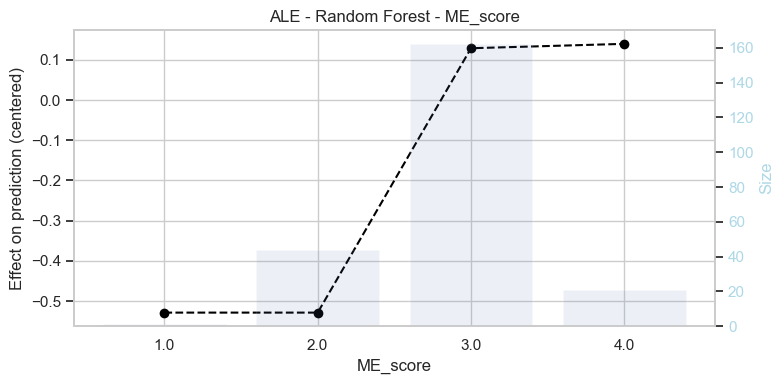

PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE for Ordinal Logistic - ME_score ===


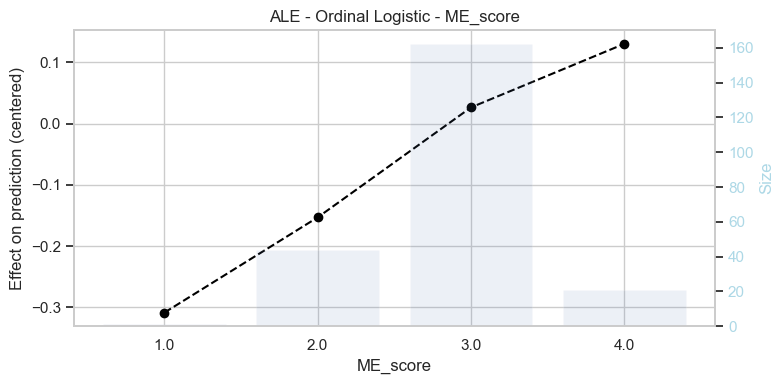

PyALE._ALE_generic:INFO: Discrete feature detected.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 21
[LightGBM] [Info] Start training from score 4.473684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

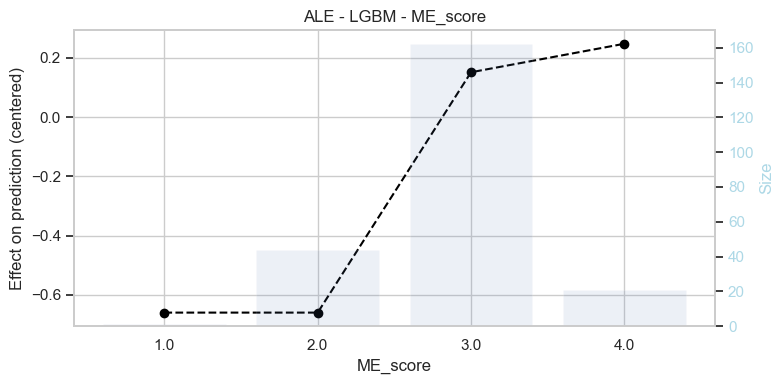

In [ ]:
for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Find best model
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instantiate and train the model
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Show ALE plot
    print(f"\n=== ALE for {label} - ME_score ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["ME_score"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - ME_score")
    plt.tight_layout()
    plt.grid(False)
    plt.savefig(output + "ml_ale_{label}.png", dpi=300) 
    plt.show()


## 6. Incorporating Sentiment Analysis from Evaluation Texts
We scrape full IEG reports, extract structured text sections, perform sentiment analysis, and include this as predictors in a final ML model.

In [42]:
# Extract text from PDFS
tqdm.pandas()

def extract_text_from_pdf(url):
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        with pdfplumber.open(BytesIO(response.content)) as pdf:
            text = ''.join(page.extract_text() or '' for page in pdf.pages)
        return text.strip()
    except Exception as e:
        return f"[ERROR] {e}"

# Aplica la función a cada fila
df_text['Full Text'] = df_text['PDF'].progress_apply(extract_text_from_pdf)

100%|██████████| 305/305 [22:03<00:00,  4.34s/it]


In [43]:
def extract_section(text, start_pattern, end_pattern, label):
    # Compile regex patterns with flexible matching
    start_regex = re.compile(rf"{start_pattern}", re.IGNORECASE)
    end_regex = re.compile(rf"{end_pattern}", re.IGNORECASE)

    # Split text into lines
    lines = text.splitlines()
    start_idx = end_idx = None

    for i, line in enumerate(lines):
        if start_idx is None and start_regex.search(line.strip()):
            start_idx = i
        elif start_idx is not None and end_regex.search(line.strip()):
            end_idx = i
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        return "\n".join(lines[start_idx:end_idx+1])
    else:
        return ""  # If no valid section is found

# Apply to DataFrame
def extract_sections(row):
    text = row['Full Text']
    me_section = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design.*Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E Section"
    )
    me_design = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design\b", 
        end_pattern=r"\bM&E\s+Implementation\b", 
        label="M&E: Design"
    )
    me_implementation = extract_section(
        text,
        start_pattern=r"\bM&E\s+Implementation\b", 
        end_pattern=r"\bM&E\s+Utilization\b", 
        label="M&E: Implementation"
    )
    me_utilization = extract_section(
        text,
        start_pattern=r"\bM&E\s+Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E: Utilization"
    )
    outcome_section = extract_section(
        text,
        start_pattern=r'[567][\.\)]?\s*Outcome\b.*',
        end_pattern=r'(IEG\s+)?Outcome\s+Rating\b.*',
        label="Outcome Section"
    )
    return pd.Series({
        'M&E Section': me_section,
        'M&E: Design': me_design,
        'M&E: Implementation': me_implementation,
        'M&E: Utilization': me_utilization,
        'Outcome Section': outcome_section
    })

# Apply to the DataFrame df_text
df_text[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome Section']] = df_text.apply(extract_sections, axis=1)

In [70]:
# Sentiment Analysis
df_text2 = df_text.copy()

def simple_sentiment(text):
    if pd.isnull(text):
        return np.nan  
    blob = TextBlob(str(text)) 
    return blob.sentiment.polarity 

df_text2['M&E Section (sentiment)'] = df_text2['M&E Section'].apply(simple_sentiment)
df_text2['M&E: Design (sentiment)'] = df_text2['M&E: Design'].apply(simple_sentiment)
df_text2['M&E: Implementation (sentiment)'] = df_text2['M&E: Implementation'].apply(simple_sentiment)
df_text2['M&E: Utilization (sentiment)'] = df_text2['M&E: Utilization'].apply(simple_sentiment)
df_text2['Lesson (sentiment)'] = df_text2['Lesson'].apply(simple_sentiment)
df_text2['Full Text (sentiment)'] = df_text2['Full Text'].apply(simple_sentiment)

aux_data = df_text2.copy()

df_text2.drop(columns=['PDF', 'Lesson', 'Full Text', 'M&E Section', 'M&E: Design', 'M&E: Implementation', 
                       'M&E: Utilization', 'Outcome Section'], inplace=True, errors='ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wb592581\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


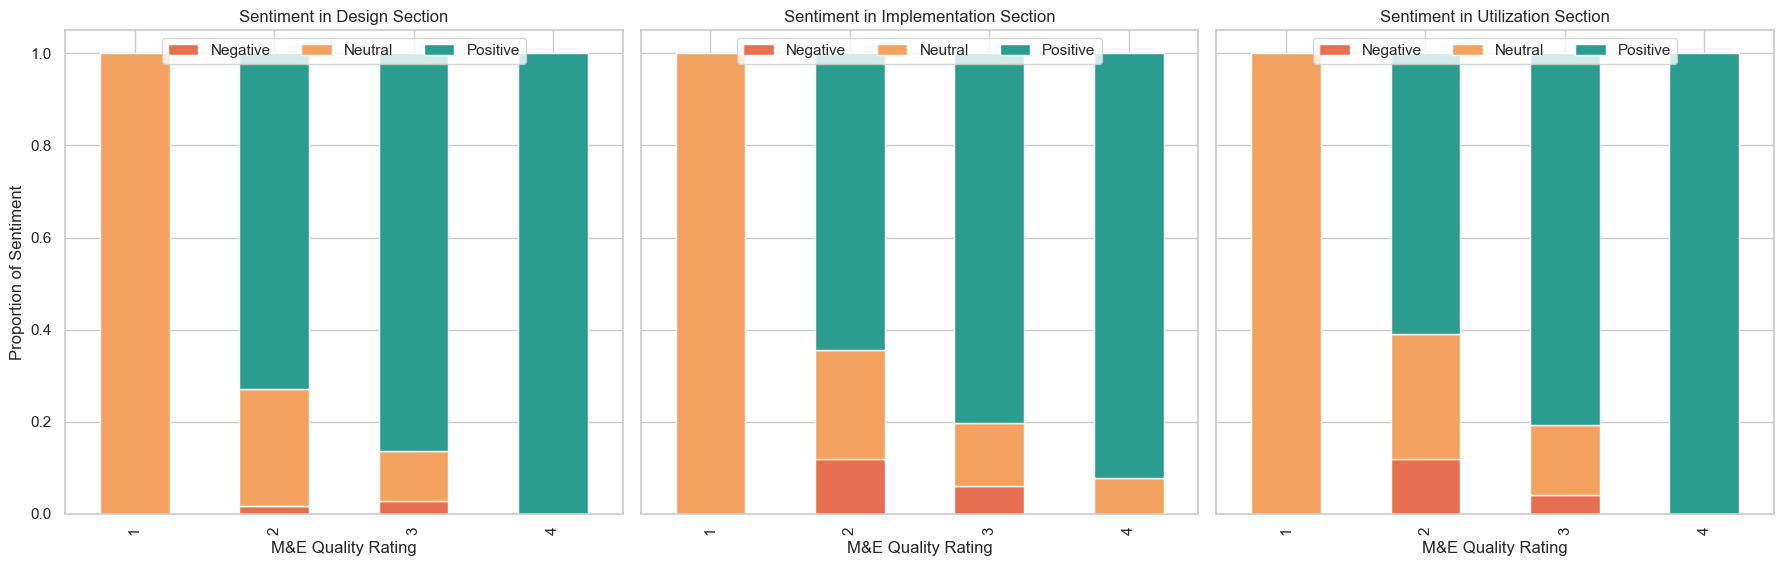

In [ ]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    if not isinstance(text, str) or text.strip() == "":
        return 'Neutral'  # Optional: could return NaN
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
aux_data['sentiment_M_E_section'] = aux_data['M&E Section'].apply(classify_sentiment_vader)
aux_data['sentiment_M_E_design'] = aux_data['M&E: Design'].apply(classify_sentiment_vader)
aux_data['sentiment_ME_implementation'] = aux_data['M&E: Implementation'].apply(classify_sentiment_vader)
aux_data['sentiment_ME_utilization'] = aux_data['M&E: Utilization'].apply(classify_sentiment_vader)

# List of sentiment columns and readable titles
sentiment_cols = ['sentiment_M_E_design', 'sentiment_ME_implementation', 'sentiment_ME_utilization']
titles = ['Design', 'Implementation', 'Utilization']

# Create figure with 3 columns (one per section)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterate over each section
for i, col in enumerate(sentiment_cols):
    # Create crosstab: rows = ratings, columns = sentiment
    ctab = pd.crosstab(aux_data['ME_score'], aux_data[col], normalize='index')
    
    # Ensure correct order of sentiment categories
    ctab = ctab[['Negative', 'Neutral', 'Positive']]

    # Ensure desired order of M&E Quality ratings
    ctab = ctab.reindex([1, 2, 3, 4])

    # Plot
    ctab.plot(kind='bar', stacked=True, ax=axes[i], color=['#e76f51', '#f4a261', '#2a9d8f'])
    axes[i].set_title(f'Sentiment in {titles[i]} Section')
    axes[i].set_xlabel('M&E Quality Rating')
    if i == 0:
        axes[i].set_ylabel('Proportion of Sentiment')
    axes[i].legend(title='', loc='upper center', ncol=3)

# Global title
fig.suptitle('', fontsize=16)
plt.tight_layout()
plt.savefig(output + "sentiments.png", dpi=300) 
plt.show()

In [72]:
############################################
########## MACHINE LEARNING MODEL ##########
############################################

df_text3 = df_text2.copy()
df_text3.drop(['Full Text (sentiment)'], inplace=True, errors='ignore')
df_text3 = df_text3.dropna(subset=['Lesson (sentiment)'])

# --------- 1. Prepare data ----------
y = df_text3['outcome_score']
X = df_text3.drop(columns=['outcome_score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

original_columns = X_train.columns

def clean_column_names(df):
    df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    return df

X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

cleaned_columns = [re.sub(r'[^\w]', '_', col) for col in original_columns]
col_name_map = dict(zip(cleaned_columns, original_columns))

# --------- 2. Objective function for Optuna ----------
N_TRIALS = 40

def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['random_forest', 'lgbm', 'ordinal_logistic'])

    if model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'random_state': 42
        }
        model = RandomForestRegressor(**params)

    elif model_type == 'lgbm':
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'random_state': 42
        }
        model = LGBMRegressor(**params)

    else:  # ordinal_logistic
        alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )

    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_train, y_train, cv=3)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    return rmse

# --------- 3. Run Optuna ----------
study = optuna.create_study(direction='minimize')  # We want to minimize RMSE
study.optimize(objective, n_trials=N_TRIALS)

best_params = study.best_params
print("Best model type and parameters:", best_params)


[I 2025-06-23 01:46:36,559] A new study created in memory with name: no-name-bc73ef19-00f5-45d3-8b4d-0a658034297a


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-06-23 01:46:36,939] Trial 0 finished with value: 0.6619063081129916 and parameters: {'model_type': 'lgbm', 'num_leaves': 56, 'learning_rate': 0.21579206653589858, 'n_estimators': 118}. Best is trial 0 with value: 0.6619063081129916.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.440000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-23 01:46:37,242] Trial 1 finished with value: 0.6590575102358757 and parameters: {'model_type': 'lgbm', 'num_leaves': 46, 'learning_rate': 0.27206174927828, 'n_estimators': 259}. Best is trial 1 with value: 0.6590575102358757.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.453333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-23 01:46:38,402] Trial 2 finished with value: 0.6363612929133714 and parameters: {'model_type': 'lgbm', 'num_leaves': 26, 'learning_rate': 0.07202597717573503, 'n_estimators': 283}. Best is trial 2 with value: 0.6363612929133714.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-23 01:46:41,200] Trial 3 finished with value: 0.8353309390761112 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.001146057896520297}. Best is trial 2 with value: 0.6363612929133714.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-06-23 01:46:41,495] Trial 4 finished with value: 0.649428945382394 and parameters: {'model_type': 'lgbm', 'num_leaves': 30, 'learning_rate': 0.2703620633923641, 'n_estimators': 147}. Best is trial 2 with value: 0.6363612929133714.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-23 01:46:42,199] Trial 5 finished with value: 0.7803133273813083 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.06471942030524623}. Best is trial 2 with value: 0.6363612929133714.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-06-23 01:46:42,518] Trial 6 finished with value: 0.6581793604732776 and parameters: {'model_type': 'lgbm', 'num_leaves': 59, 'learning_rate': 0.20287913553600206, 'n_estimators': 200}. Best is trial 2 with value: 0.6363612929133714.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.440000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-23 01:46:42,855] Trial 7 finished with value: 0.642468511256667 and parameters: {'model_type': 'lgbm', 'num_leaves': 24, 'learning_rate': 0.19879683987040134, 'n_estimators': 250}. Best is trial 2 with value: 0.6363612929133714.
[I 2025-06-23 01:46:45,612] Trial 8 finished with value: 0.5860328176402417 and parameters: {'model_type': 'random_forest', 'n_estimators': 266, 'max_depth': 19}. Best is trial 8 with value: 0.5860328176402417.
[I 2025-06-23 01:46:45,766] Trial 9 finished with value: 0.6346617865663452 and parameters: {'model_type': 'lgbm', 'num_leaves': 94, 'learning_rate': 0.2325265018621397, 'n_estimators': 178}. Best is trial 8 with value: 0.5860328176402417.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-23 01:46:48,342] Trial 10 finished with value: 0.586625432578701 and parameters: {'model_type': 'random_forest', 'n_estimators': 240, 'max_depth': 20}. Best is trial 8 with value: 0.5860328176402417.
[I 2025-06-23 01:46:50,278] Trial 11 finished with value: 0.5860968079313374 and parameters: {'model_type': 'random_forest', 'n_estimators': 234, 'max_depth': 20}. Best is trial 8 with value: 0.5860328176402417.
[I 2025-06-23 01:46:52,565] Trial 12 finished with value: 0.5865555162790625 and parameters: {'model_type': 'random_forest', 'n_estimators': 221, 'max_depth': 20}. Best is trial 8 with value: 0.5860328176402417.
[I 2025-06-23 01:46:55,057] Trial 13 finished with value: 0.5862999526107666 and parameters: {'model_type': 'random_forest', 'n_estimators': 300, 'max_depth': 16}. Best is trial 8 with value: 0.5860328176402417.
[I 2025-06-23 01:46:56,772] Trial 14 finished with value: 0.6178042910975531 and parameters: {'model_type': 'random_forest', 'n_estimators': 211, 'max_de

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-23 01:47:41,186] Trial 38 finished with value: 0.7601169500660919 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.15367381358666768}. Best is trial 35 with value: 0.5855825311949623.
[I 2025-06-23 01:47:43,533] Trial 39 finished with value: 0.5856069001362061 and parameters: {'model_type': 'random_forest', 'n_estimators': 291, 'max_depth': 17}. Best is trial 35 with value: 0.5855825311949623.


Best model type and parameters: {'model_type': 'random_forest', 'n_estimators': 292, 'max_depth': 17}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\wb592581\AppData\Local\Temp\ipykernel_20920\3522585085.py:51: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=ax, palette=palette)


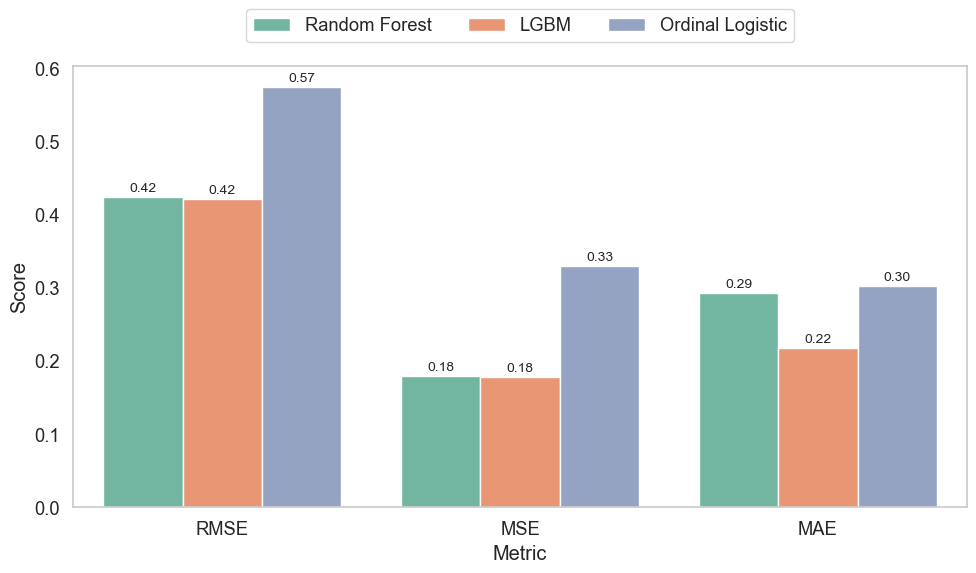

In [ ]:
results_test = []

for model_type in ['random_forest', 'lgbm', 'ordinal_logistic']:
    # Extract the best trial for each model type
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instantiate the model
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        label = 'Random Forest'
    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        label = 'LGBM'
    else:  # ordinal_logistic
        alpha = best_params['alpha']
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )
        label = 'Ordinal Logistic'

    # Train the model
    model.fit(X_train, y_train)

    # TEST predictions
    y_test_pred = model.predict(X_test)
    results_test.append({
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred)
    })

# Reformat results
test_df = pd.DataFrame(results_test).melt(id_vars='Model', var_name='Metric', value_name='Score')

# --------- PLOT (Test Only) ---------
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set2")

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=ax, palette=palette)
ax.set_title("", fontsize=14)
ax.set_ylabel("Score")
ax.set_xlabel("Metric")

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10, label_type='edge', padding=2)

# Configure legend (single row)
ax.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.grid(False, axis='y')

plt.tight_layout()
plt.savefig(output + "ml_metrics_sent.png", dpi=300) 
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

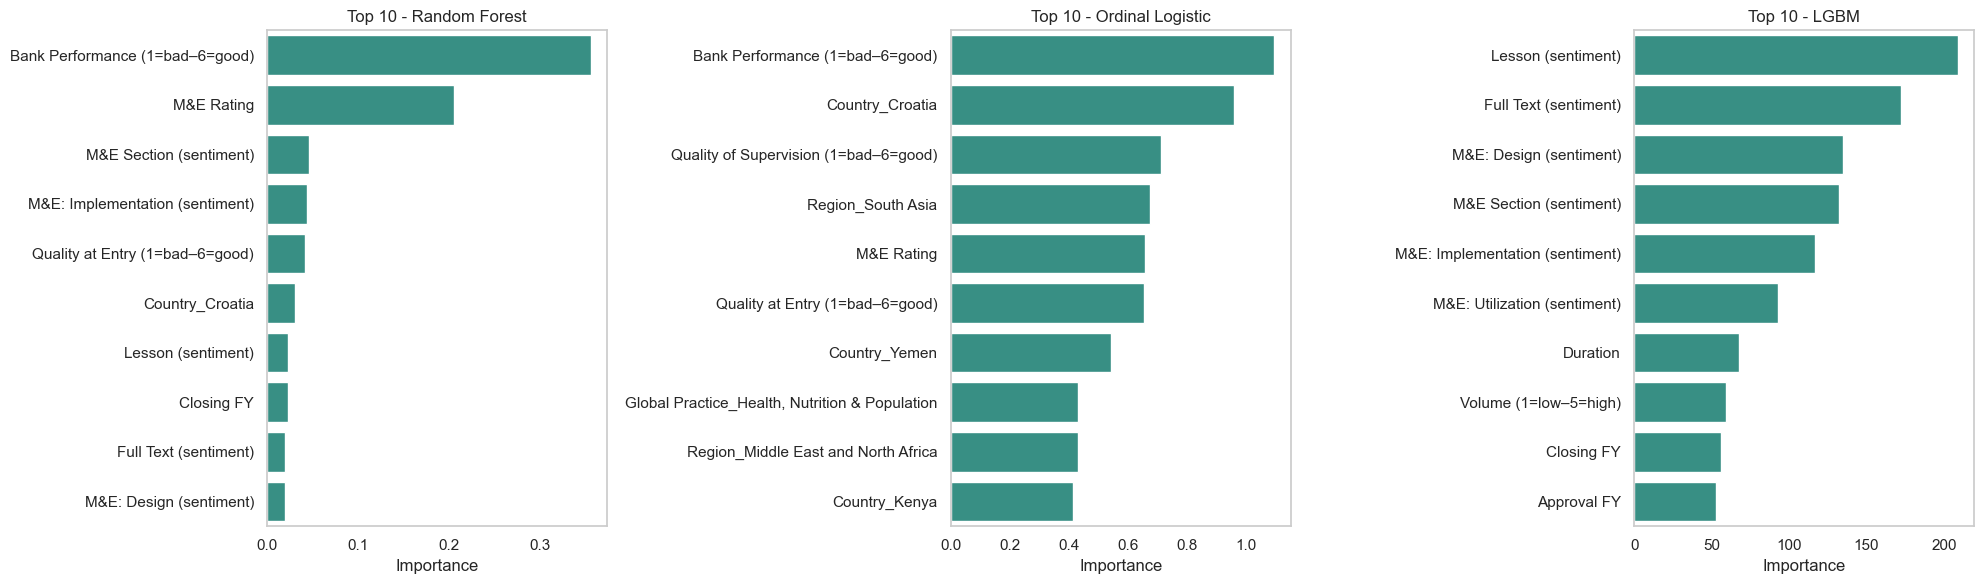

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, (model_type, label) in enumerate([
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]):
    # Find the best trial for this model
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)  # use min since we're minimizing RMSE
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instantiate and train the model
    if model_type == 'random_forest':
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    elif model_type == 'lgbm':
        from lightgbm import LGBMRegressor
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    else:  # ordinal_logistic
        from mord import LogisticAT
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import StandardScaler
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)
        # Extract coefficients from internal LogisticAT model
        coefs = model.named_steps['logisticat'].coef_
        importances = np.abs(coefs)

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(10)

    # Relabel 'ME_score' to 'M&E Rating'
    importance_df['feature'] = importance_df['feature'].map(
        lambda x: 'M&E Rating' if col_name_map.get(x, x) == 'ME_score' else col_name_map.get(x, x)
    )

    # Plot
    sns.barplot(data=importance_df, x='importance', y='feature', ax=axs[i], color="#2a9d8f")
    axs[i].set_title(f"Top 10 - {label}")
    axs[i].set_xlabel("Importance")
    axs[i].set_ylabel("")
    axs[i].grid(False)

plt.tight_layout()
plt.savefig(output + "ml_importance_sent.png", dpi=300) 
plt.show()


PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE for Random Forest - ME_score ===


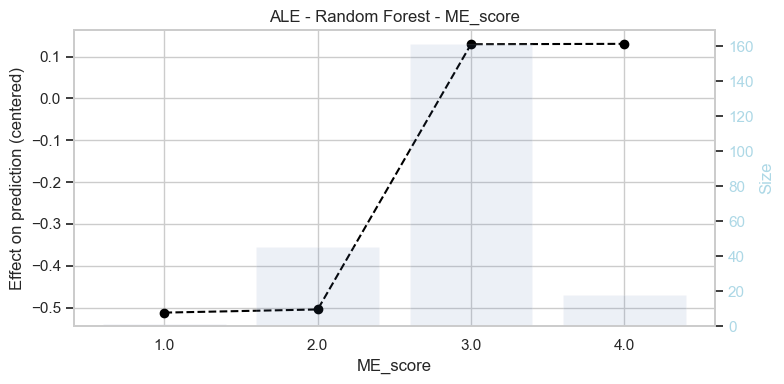

PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE for Ordinal Logistic - ME_score ===


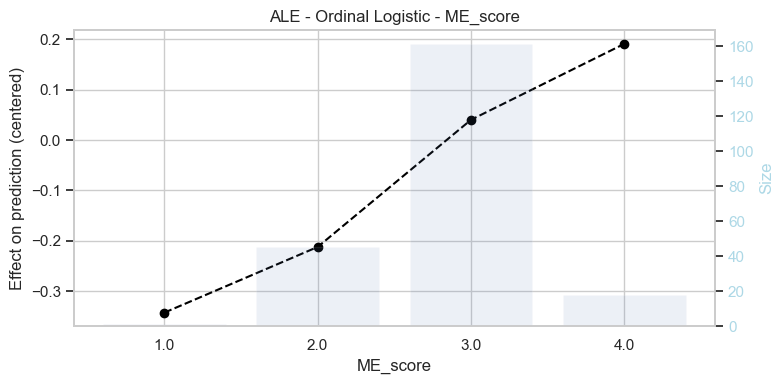

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

PyALE._ALE_generic:INFO: Discrete feature detected.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

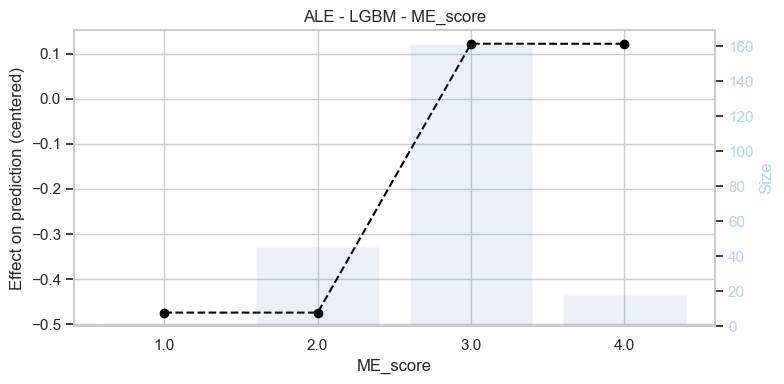

In [78]:
for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Find the best model
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instantiate and train the model
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Display ALE
    print(f"\n=== ALE for {label} - ME_score ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["ME_score"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - ME_score")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE for Random Forest - M_E__Implementation__sentiment_ ===


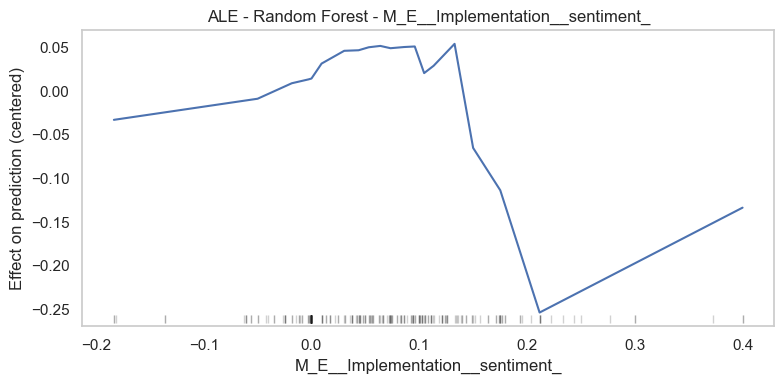

PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE for Ordinal Logistic - M_E__Implementation__sentiment_ ===


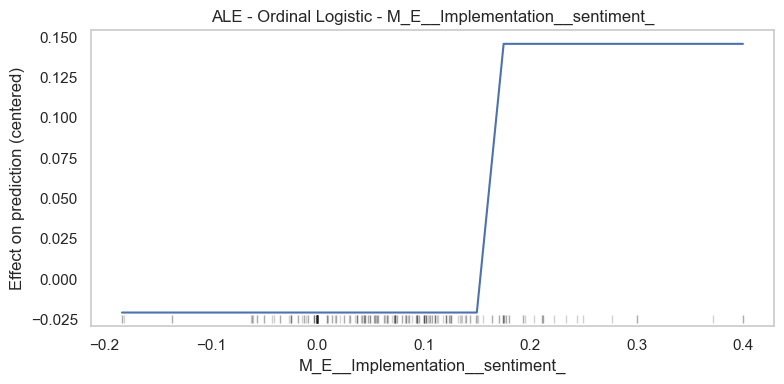

PyALE._ALE_generic:INFO: Continuous feature detected.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

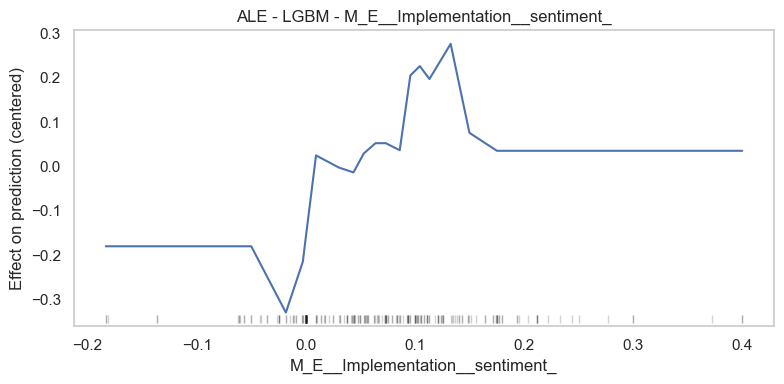

In [79]:
for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Find the best model
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instantiate and train the model
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Display ALE
    print(f"\n=== ALE for {label} - M_E__Implementation__sentiment_ ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["M_E__Implementation__sentiment_"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - M_E__Implementation__sentiment_")
    plt.tight_layout()
    plt.grid(False)
    plt.show()
